In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.decomposition import PCA
import pickle

In [2]:
image_dir = "DATA/"
image_size = (224, 224) # VGG16 Requirements

In [3]:
# Load Pretrained Model
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

In [4]:
def load_and_preprocess_image(image_path, target_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [5]:
# Load Images
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(
    image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

all_features = []

# Extract features
for img_path in image_paths:
    img = load_and_preprocess_image(img_path, image_size)
    features = model.predict(img)  # Extract features using VGG16
    features_flattened = features.flatten()  # Flatten features
    all_features.append(features_flattened)

all_features = np.array(all_features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [39]:
# Optional: Reduce dimensionality using PCA
pca = PCA(n_components=51)
pca_features = pca.fit_transform(all_features)

In [40]:
with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)

### K-Means Clustering Implementation

In [41]:
# Euclidean distance
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# Initialize Centroid
def initialize_centroids(data, k):
    np.random.seed(42)
    random_indices = np.random.permutation(data.shape[0])
    centroids = data[random_indices[:k]]
    return centroids

# Clustering
def assign_clusters(data, centroids):
    clusters = []
    for point in data:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        closest_centroid = np.argmin(distances)
        clusters.append(closest_centroid)
    return np.array(clusters)

# Update centroids
def update_centroids(data, clusters, k):
    new_centroids = []
    for i in range(k):
        cluster_points = data[clusters == i]
        if len(cluster_points) > 0:
            new_centroids.append(cluster_points.mean(axis=0))
        else:            
            new_centroids.append(data[np.random.choice(data.shape[0])])
    return np.array(new_centroids)

# K-Means
def kmeans(data, k, max_iters=100, tol=1e-4):
    # Step 1: Initialize centroids
    centroids = initialize_centroids(data, k)
    
    for i in range(max_iters):
        # Step 2: Assign clusters
        clusters = assign_clusters(data, centroids)
        
        # Step 3: Update centroids
        new_centroids = update_centroids(data, clusters, k)
        
        # Step 4: Check for convergence (if centroids don't change)
        if np.all(np.abs(new_centroids - centroids) < tol):            
            break
        
        centroids = new_centroids

    return clusters, centroids


In [42]:
k = 8

labels, centroids = kmeans(pca_features, k)

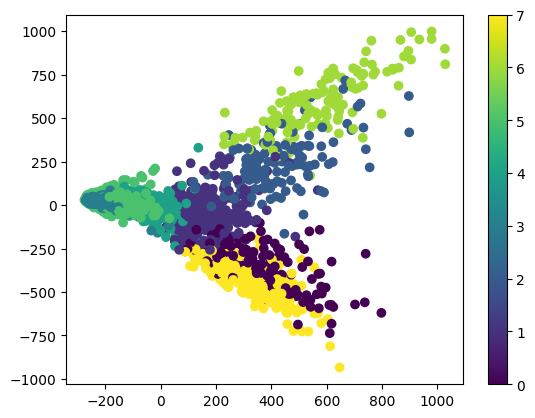

In [43]:
# Visualize clusters
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis')
plt.colorbar()
plt.show()

In [44]:
# Output the labels for each image
for img_path, label in zip(image_paths, labels):
    print(f"Image: {img_path}, Cluster: {label}")

Image: DATA/airport_1.jpg, Cluster: 1
Image: DATA/airport_10.jpg, Cluster: 1
Image: DATA/airport_100.jpg, Cluster: 4
Image: DATA/airport_101.jpg, Cluster: 1
Image: DATA/airport_102.jpg, Cluster: 1
Image: DATA/airport_103.jpg, Cluster: 1
Image: DATA/airport_104.jpg, Cluster: 1
Image: DATA/airport_105.jpg, Cluster: 1
Image: DATA/airport_106.jpg, Cluster: 1
Image: DATA/airport_107.jpg, Cluster: 1
Image: DATA/airport_108.jpg, Cluster: 1
Image: DATA/airport_109.jpg, Cluster: 1
Image: DATA/airport_11.jpg, Cluster: 1
Image: DATA/airport_110.jpg, Cluster: 1
Image: DATA/airport_111.jpg, Cluster: 1
Image: DATA/airport_112.jpg, Cluster: 1
Image: DATA/airport_113.jpg, Cluster: 1
Image: DATA/airport_114.jpg, Cluster: 1
Image: DATA/airport_115.jpg, Cluster: 1
Image: DATA/airport_116.jpg, Cluster: 1
Image: DATA/airport_117.jpg, Cluster: 1
Image: DATA/airport_118.jpg, Cluster: 1
Image: DATA/airport_119.jpg, Cluster: 4
Image: DATA/airport_12.jpg, Cluster: 1
Image: DATA/airport_120.jpg, Cluster: 1
Image

In [45]:
result = pd.DataFrame({
    'path': np.ravel(image_paths),
    'label': np.ravel(labels)
})

result

,path,label
0,DATA/airport_1.jpg,1
1,DATA/airport_10.jpg,1
2,DATA/airport_100.jpg,4
3,DATA/airport_101.jpg,1
4,DATA/airport_102.jpg,1
...,...,...
2715,DATA/stadium_95.jpg,6
2716,DATA/stadium_96.jpg,6
2717,DATA/stadium_97.jpg,2
2718,DATA/stadium_98.jpg,2


In [46]:
clusters = ['airport', 'beach', 'denseresidential', 'desert', 'farmland', 'mountain', 'stadium', 'forest']

In [47]:
for cluster in clusters:
    observe = result[result['path'].str.contains(cluster)]
    
    mode = observe['label'].mode()[0]
    
    print("{} : {}".format(cluster, mode))

airport : 1
beach : 5
denseresidential : 7
desert : 5
farmland : 4
mountain : 3
stadium : 2
forest : 3


In [48]:
for cluster in clusters:
    observe = result[result['path'].str.contains(cluster)]
    
    unique = observe['label'].value_counts()

    print("{}\n{}\n".format(cluster, unique))

airport
label
1    331
4     28
6      1
Name: count, dtype: int64

beach
label
5    388
3      9
1      2
4      1
Name: count, dtype: int64

denseresidential
label
7    195
0    148
1     46
4     14
5      5
3      2
Name: count, dtype: int64

desert
label
5    281
3     19
Name: count, dtype: int64

farmland
label
4    356
3     10
5      2
1      2
Name: count, dtype: int64

mountain
label
3    194
5    144
1      2
Name: count, dtype: int64

stadium
label
2    130
6    129
1     25
4      4
0      2
Name: count, dtype: int64

forest
label
3    249
5      1
Name: count, dtype: int64



In [49]:
centroids = pd.DataFrame(centroids)

centroids.to_csv('centroids.csv')